# Recommendation & Accuracy 

GOALS:::

Recommendation Strategies
1. k constant: recommend with k many papers
2. k parameter: threshold on the papers

Evaluation Strategies
1. Accuracy metrics
2. Discovery-oriented metrics
"""


# Example

In [101]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../../')
import random
import preprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from collections import defaultdict
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)
from surprise import SVD, SVDpp, NMF
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate,  KFold


### Below tic toc from https://stackoverflow.com/questions/5849800/tic-toc-functions-analog-in-python
import time
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

###all rights to below for these functions
###http://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def precision_recall_at_k(est_mat, items_in_trainset_of_users_in_testset, true_r, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

#     # First map the predictions to each user.
#     user_est_true = defaultdict(list)
#     for uid, _, true_r, est, _ in predictions:
#         user_est_true[uid].append((est, true_r))
    users = items_in_trainset_of_users_in_testset.keys()
    precisions = dict()
    recalls = dict()
    
    for user in users:
        all_est = est_mat[user]
        items_to_be_ignored = [item for item,rating in items_in_trainset_of_users_in_testset[user]]
        ests = [all_est[k] for k in range(len(all_est)) if k not in items_to_be_ignored]
        ests = np.array(ests)
        idx = np.argsort(-ests)
        sorted_ests = ests[idx]
        
        true_ratings = np.zeros(len(all_est))
        for k in range(len(true_ratings)):
            if k in true_r[user].keys():
                true_ratings[k] = true_r[user][k]
        sorted_ratings = true_ratings[idx]
        
        n_rel = sum(sorted_ratings > threshold)
        n_rec_k = sum((est > threshold) for est in sorted_ests[:k]) 
        idx_n_rel_k = [rat > threshold for rat in sorted_ratings[:k]]
        top_k_ests = sorted_ests[:k]
#         n_rel_and_rec_k = sum(((est > threshold) and (rat > threshold)) for (est, rat) in (sorted_ests[:k],sorted_ratings[:k]))
        n_rel_and_rec_k = sum((est>threshold) for est in top_k_ests[idx_n_rel_k])
        precisions[user] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[user] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        
#     for uid, user_ratings in user_est_true.items():

#         # Sort user ratings by estimated value
#         user_ratings.sort(key=lambda x: x[0], reverse=True)

#         # Number of relevant items
#         n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

#         # Number of recommended items in top k
#         n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

#         # Number of relevant and recommended items in top k
#         n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
#                               for (est, true_r) in user_ratings[:k])

#         # Precision@K: Proportion of recommended items that are relevant
#         precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

#         # Recall@K: Proportion of relevant items that are recommended
#         recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    

    return precisions, recalls




# Recommendation System
## 1. Un-Normalized Case with SVD(biased=False)
### 1.1 Regularization Hyperparameter search


In [3]:
"""
Un-Normalized Case.
"""

random_dict = preprocess.create_random_subset_user_paper_data(debug=True)
rating_scale = (1,11)
trainset, testset = preprocess.user_paper_train_test_split(random_dict, test_size = .2)
trainset = preprocess.create_surprise_user_paper_data(trainset, rating_scale).build_full_trainset()
testset = preprocess.create_surprise_user_paper_data(testset, rating_scale).build_full_trainset().build_testset()

In [5]:
# Regularization Hyperparameter Search 1.
lambdas = 10.0**np.arange(-7,3)
test_loss_possible_rmse = np.zeros(len(lambdas))
test_loss_all_rmse = np.zeros(len(lambdas))
test_loss_possible_mae = np.zeros(len(lambdas))
test_loss_all_mae = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    algo = SVD(biased=False, n_epochs = 100,reg_all=lambdas[i])
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions)
    test_loss_all_rmse[i] = accuracy.rmse(predictions)
    test_loss_possible_mae[i] = accuracy.mae(possible_predictions)
    test_loss_all_mae[i] = accuracy.mae(predictions)

hihihihihihi
RMSE: 1.0537
RMSE: 0.8594
MAE:  0.9844
MAE:  0.6615
hihihihihihi
RMSE: 1.0552
RMSE: 0.8607
MAE:  0.9870
MAE:  0.6632
hihihihihihi
RMSE: 1.0562
RMSE: 0.8614
MAE:  0.9892
MAE:  0.6646
hihihihihihi
RMSE: 1.0518
RMSE: 0.8580
MAE:  0.9850
MAE:  0.6619
hihihihihihi
RMSE: 1.0534
RMSE: 0.8593
MAE:  0.9865
MAE:  0.6629
hihihihihihi
RMSE: 1.0456
RMSE: 0.8530
MAE:  0.9846
MAE:  0.6617
hihihihihihi
RMSE: 1.0265
RMSE: 0.8378
MAE:  0.9820
MAE:  0.6599
hihihihihihi
RMSE: 1.0675
RMSE: 0.8705
MAE:  1.0407
MAE:  0.6981
hihihihihihi
RMSE: 1.0704
RMSE: 0.8728
MAE:  1.0436
MAE:  0.7000
hihihihihihi
RMSE: 1.0704
RMSE: 0.8728
MAE:  1.0436
MAE:  0.7000


In [4]:
# lambda = 10^-1 works best for all four accuracies.
# Set reg_all = 10^-1
# Now let's do precision and recall.
algo = SVD(biased=False, n_epochs = 100,reg_all=10**(-1))
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    

hihihihihihi


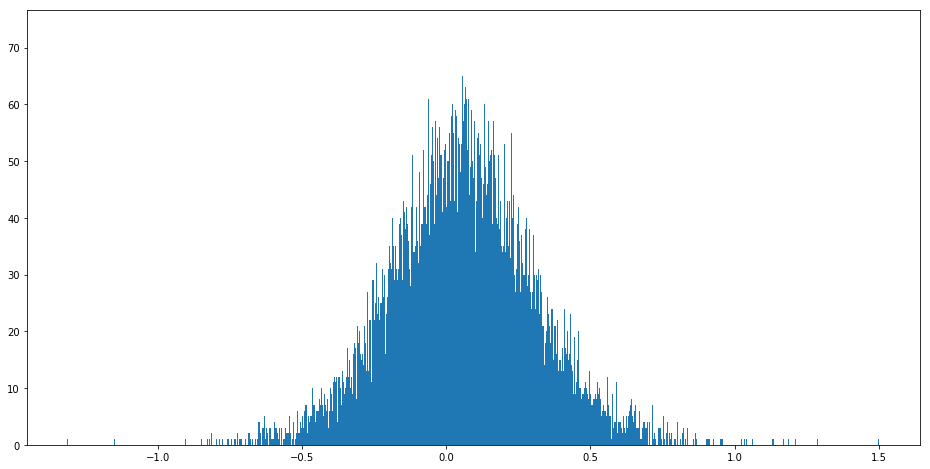

(0.058535069763064863, 0.25363236414386225, 1.5003439834864005)

In [66]:
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(possible_predictions)):
    estimations.append(possible_predictions[idx].est)

plt.hist(estimations,bins=1000)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations)


### 1.2 Precision and Recall


In [12]:
P = algo.pu
Q = algo.qi
est_mat = P.dot(Q.T)

In [96]:
users_testset = set()
for user,_,_ in testset:
    users_testset.add(user)
items_in_trainset_of_users_in_testset = defaultdict(list)
for user in users_testset:
    items_in_trainset_of_users_in_testset[trainset.to_inner_uid(user)] = trainset.ur[trainset.to_inner_uid(user)]
    
true_r = defaultdict(partial(defaultdict, int))
for user, paper, rating in testset:
    try:
        true_r[trainset.to_inner_uid(user)][trainset.to_inner_iid(paper)] = rating
    except ValueError:
        pass

In [108]:
# top_n_all = get_top_n(predictions, n=k)
# top_n_possible = get_top_n(possible_predictions, n=k)
# # Print the recommended items for each user
# for uid, user_ratings in top_n_possible.items():
#     print(uid, [iid for (iid, _) in user_ratings], '\n')

k = 40
thresholds = [-0.1,0,0.1,0.2,0.3,0.4]
precision_hist = np.zeros(len(thresholds))
recall_hist = np.zeros(len(thresholds))
for t,threshold in enumerate(thresholds):

    # precisions_all, recalls_all = precision_recall_at_k(predictions, k=k, threshold=threshold)
    precisions_possible, recalls_possible = precision_recall_at_k(est_mat, items_in_trainset_of_users_in_testset, true_r, k=k, threshold=threshold)

    # Precision and recall can then be averaged over all users
    # print('Precision for all:        '+str(sum(prec for prec in precisions_all.values()) / len(precisions_all)))
    # print('Recall for all:           '+str(sum(rec for rec in recalls_all.values()) / len(recalls_all)))
    
    
    precision_hist[t] = sum(prec for prec in precisions_possible.values()) / len(precisions_possible)
    print('Precision for possible:   '+str(precision_hist[t]))
    recall_hist[t] = sum(rec for rec in recalls_possible.values()) / len(recalls_possible)
    print('Recall for possible:      '+str(recall_hist[t]))
    
    

Precision for possible:   1.0
Recall for possible:      0.7567403777632826
Precision for possible:   9.160175823714604e-05
Recall for possible:      0.5291766683169881
Precision for possible:   0.00010117530778665835
Recall for possible:      0.27844713855846775
Precision for possible:   0.0001253592317702447
Recall for possible:      0.11229417057324009
Precision for possible:   0.00021084611056936586
Recall for possible:      0.03646112415135633
Precision for possible:   0.0006968147665640273
Recall for possible:      0.010754044135802979


Text(0,0.5,'recall')

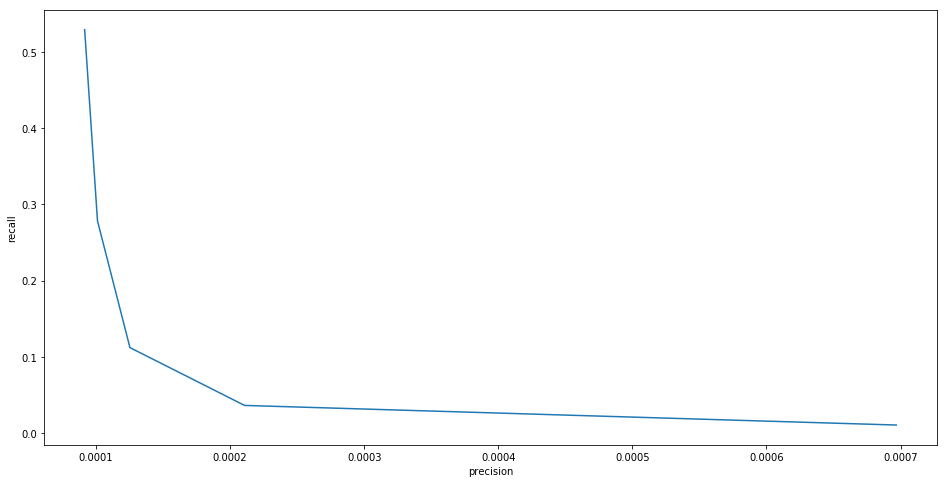

In [114]:
plt.plot(precision_hist[1:],recall_hist[1:])
plt.xlabel('precision')
plt.ylabel('recall')

## 2. Normalized Case with SVD(biased=False)
### 2.1 Reg. Param. Search

In [109]:
random_dict = preprocess.create_random_subset_user_paper_data(debug=True)
rating_scale = (1,5)
random_dict = preprocess.normalize_user_paper_data(random_dict, rating_scale)
trainset, testset = preprocess.user_paper_train_test_split(random_dict, test_size = .2)
trainset = preprocess.create_surprise_user_paper_data(trainset, rating_scale).build_full_trainset()
testset = preprocess.create_surprise_user_paper_data(testset, rating_scale).build_full_trainset().build_testset()

In [110]:
# Regularization Hyperparameter Search 1.
lambdas = 10.0**np.arange(-7,3)
test_loss_possible_rmse = np.zeros(len(lambdas))
test_loss_all_rmse = np.zeros(len(lambdas))
test_loss_possible_mae = np.zeros(len(lambdas))
test_loss_all_mae = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    algo = SVD(biased=False, n_epochs = 100,reg_all=lambdas[i])
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions)
    test_loss_all_rmse[i] = accuracy.rmse(predictions)
    test_loss_possible_mae[i] = accuracy.mae(possible_predictions)
    test_loss_all_mae[i] = accuracy.mae(predictions)

hihihihihihi
RMSE: 1.3493
RMSE: 1.1708
MAE:  1.0863
MAE:  0.7861
hihihihihihi
RMSE: 1.3491
RMSE: 1.1706
MAE:  1.0902
MAE:  0.7886
hihihihihihi
RMSE: 1.3606
RMSE: 1.1792
MAE:  1.0956
MAE:  0.7921
hihihihihihi
RMSE: 1.3473
RMSE: 1.1692
MAE:  1.0859
MAE:  0.7858
hihihihihihi
RMSE: 1.3524
RMSE: 1.1731
MAE:  1.0873
MAE:  0.7867
hihihihihihi
RMSE: 1.3407
RMSE: 1.1643
MAE:  1.0803
MAE:  0.7822
hihihihihihi
RMSE: 1.3258
RMSE: 1.1531
MAE:  1.0837
MAE:  0.7844
hihihihihihi
RMSE: 1.3686
RMSE: 1.1853
MAE:  1.1441
MAE:  0.8237
hihihihihihi
RMSE: 1.3789
RMSE: 1.1930
MAE:  1.1517
MAE:  0.8286
hihihihihihi
RMSE: 1.3789
RMSE: 1.1930
MAE:  1.1517
MAE:  0.8286


In [128]:
# find best lambda
# plt.semilogx(lambdas,test_loss_all_mae) #10^-2
# plt.semilogx(lambdas,test_loss_possible_mae) # 10^-2
# plt.semilogx(lambdas,test_loss_all_rmse) # 10^-1
# plt.semilogx(lambdas,test_loss_possible_rmse) #10^-1

# Choose lambda = 10^-1
algo = SVD(biased=False, n_epochs = 100,reg_all=10**(-1))
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]

hihihihihihi


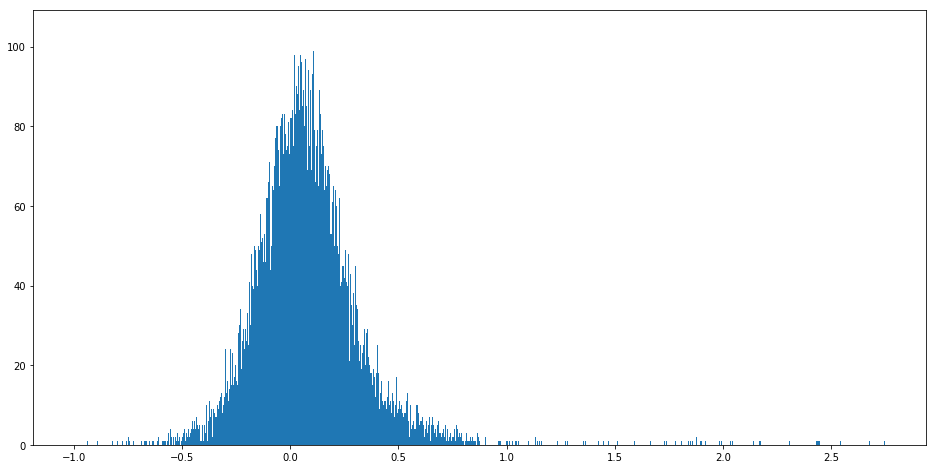

(0.078772815336459218, 0.25472811159707054, 2.7484662431918156)

In [130]:
#Estimation distribution
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(possible_predictions)):
    estimations.append(possible_predictions[idx].est)

plt.hist(estimations,bins=1000)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations)

### 2.2 Prec&Rec 

In [132]:
# top_n_all = get_top_n(predictions, n=k)
# top_n_possible = get_top_n(possible_predictions, n=k)
# # Print the recommended items for each user
# for uid, user_ratings in top_n_possible.items():
#     print(uid, [iid for (iid, _) in user_ratings], '\n')

k = 40
threshold = 0.3

precisions_all, recalls_all = precision_recall_at_k(predictions, k=k, threshold=threshold)
precisions_possible, recalls_possible = precision_recall_at_k(possible_predictions, k=k, threshold=threshold)

# Precision and recall can then be averaged over all users
print('Precision for all:        '+str(sum(prec for prec in precisions_all.values()) / len(precisions_all)))
print('Precision for possible:   '+str(sum(prec for prec in precisions_possible.values()) / len(precisions_possible)))
print('Recall for all:           '+str(sum(rec for rec in recalls_all.values()) / len(recalls_all)))
print('Recall for possible:      '+str(sum(rec for rec in recalls_possible.values()) / len(recalls_possible)))

Precision for all:        0.888036809816
Precision for possible:   0.29057187017
Recall for all:           0.389628342818
Recall for possible:      0.082671544623


## 3. Un-Nomalized with SVDpp
### 3.1 Reg. Param. Search

In [2]:
"""
Un-Normalized Case.
"""

random_dict = preprocess.create_random_subset_user_paper_data(debug=True)
rating_scale = (1,11)
trainset, testset = preprocess.user_paper_train_test_split(random_dict, test_size = .2)
trainset = preprocess.create_surprise_user_paper_data(trainset, rating_scale).build_full_trainset()
testset = preprocess.create_surprise_user_paper_data(testset, rating_scale).build_full_trainset().build_testset()

In [3]:
# Regularization Hyperparameter Search 1.
lambdas = 10.0**np.arange(-7,3)
test_loss_possible_rmse = np.zeros(len(lambdas))
test_loss_all_rmse = np.zeros(len(lambdas))
test_loss_possible_mae = np.zeros(len(lambdas))
test_loss_all_mae = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    tic()
    algo = SVDpp(n_epochs = 20,reg_all=lambdas[i])
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions)
    test_loss_all_rmse[i] = accuracy.rmse(predictions)
    test_loss_possible_mae[i] = accuracy.mae(possible_predictions)
    test_loss_all_mae[i] = accuracy.mae(predictions)
    toc()

hihihihihihi
RMSE: 0.2417
RMSE: 0.2417
MAE:  0.0906
MAE:  0.0906
Elapsed time: 49.677597 seconds.

hihihihihihi
RMSE: 0.2399
RMSE: 0.2399
MAE:  0.0900
MAE:  0.0900
Elapsed time: 49.313492 seconds.

hihihihihihi
RMSE: 0.2412
RMSE: 0.2412
MAE:  0.0903
MAE:  0.0903
Elapsed time: 47.933413 seconds.

hihihihihihi
RMSE: 0.2416
RMSE: 0.2416
MAE:  0.0898
MAE:  0.0898
Elapsed time: 49.015254 seconds.

hihihihihihi
RMSE: 0.2400
RMSE: 0.2400
MAE:  0.0894
MAE:  0.0894
Elapsed time: 50.335692 seconds.

hihihihihihi
RMSE: 0.2397
RMSE: 0.2397
MAE:  0.0882
MAE:  0.0882
Elapsed time: 50.436306 seconds.

hihihihihihi
RMSE: 0.2382
RMSE: 0.2382
MAE:  0.0802
MAE:  0.0802
Elapsed time: 49.366941 seconds.

hihihihihihi
RMSE: 0.2396
RMSE: 0.2396
MAE:  0.0674
MAE:  0.0674
Elapsed time: 49.861464 seconds.

hihihihihihi
RMSE: 0.2468
RMSE: 0.2468
MAE:  0.0676
MAE:  0.0676
Elapsed time: 49.851951 seconds.

hihihihihihi
RMSE: 0.2498
RMSE: 0.2498
MAE:  0.0680
MAE:  0.0680
Elapsed time: 49.311751 seconds.



In [31]:
# find best lambda
# plt.semilogx(lambdas,test_loss_all_mae) #10^0
# plt.semilogx(lambdas,test_loss_possible_mae) # 10^0
# plt.semilogx(lambdas,test_loss_all_rmse) # 10^-1
# plt.semilogx(lambdas,test_loss_possible_rmse) #10^-1

# In SVDpp, possible_predictions = predictions
# Choose lambda = 10^-1
algo = SVDpp(n_epochs = 20,reg_all=10**(-1))
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
# possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]

hihihihihihi


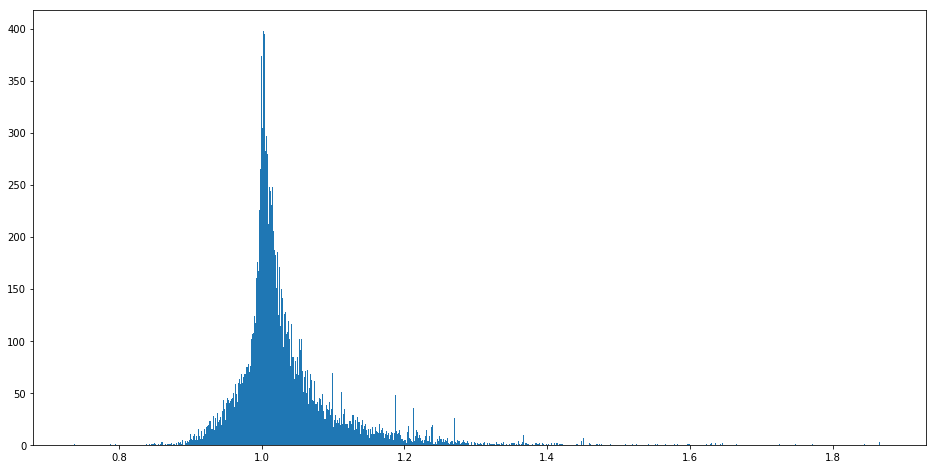

(1.0338699277045209, 0.075218360560702538, 1.8739508180242221)

In [32]:
#Estimation distribution
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(predictions)):
    estimations.append(predictions[idx].est)

plt.hist(estimations,bins=1000)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations)

### 3.2 Prec&Rec 

In [61]:
# top_n_all = get_top_n(predictions, n=k)
# top_n_possible = get_top_n(possible_predictions, n=k)
# # Print the recommended items for each user
# for uid, user_ratings in top_n_possible.items():
#     print(uid, [iid for (iid, _) in user_ratings], '\n')

k = 40
threshold = 1

precisions_all, recalls_all = precision_recall_at_k(predictions, k=k, threshold=threshold)
precisions_possible, recalls_possible = precision_recall_at_k(possible_predictions, k=k, threshold=threshold)

# Precision and recall can then be averaged over all users
print('Precision for all:        '+str(sum(prec for prec in precisions_all.values()) / len(precisions_all)))
# print('Precision for possible:   '+str(sum(prec for prec in precisions_possible.values()) / len(precisions_possible)))
print('Recall for all:           '+str(sum(rec for rec in recalls_all.values()) / len(recalls_all)))
# print('Recall for possible:      '+str(sum(rec for rec in recalls_possible.values()) / len(recalls_possible)))

Precision for all:        0.972903885481
Recall for all:           0.681808444375


## 4. Normalized with SVDpp
### 4.1 Reg. Param. Search

In [62]:
random_dict = preprocess.create_random_subset_user_paper_data(debug=True)
rating_scale = (1,5)
random_dict = preprocess.normalize_user_paper_data(random_dict, rating_scale)
trainset, testset = preprocess.user_paper_train_test_split(random_dict, test_size = .2)
trainset = preprocess.create_surprise_user_paper_data(trainset, rating_scale).build_full_trainset()
testset = preprocess.create_surprise_user_paper_data(testset, rating_scale).build_full_trainset().build_testset()

In [63]:
# Regularization Hyperparameter Search 1.
lambdas = 10.0**np.arange(-3,2)
# test_loss_possible_rmse = np.zeros(len(lambdas))
test_loss_all_rmse = np.zeros(len(lambdas))
# test_loss_possible_mae = np.zeros(len(lambdas))
test_loss_all_mae = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    algo = SVDpp(n_epochs = 20,reg_all=lambdas[i])
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
#     test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions)
    test_loss_all_rmse[i] = accuracy.rmse(predictions)
#     test_loss_possible_mae[i] = accuracy.mae(possible_predictions)
    test_loss_all_mae[i] = accuracy.mae(predictions)

hihihihihihi
RMSE: 0.6988
MAE:  0.2473
hihihihihihi
RMSE: 0.6992
MAE:  0.2457
hihihihihihi
RMSE: 0.6989
MAE:  0.2369
hihihihihihi
RMSE: 0.7087
MAE:  0.2259
hihihihihihi
RMSE: 0.7335
MAE:  0.2314


In [66]:
# find best lambda
# plt.semilogx(lambdas,test_loss_all_mae) #10^0
# plt.semilogx(lambdas,test_loss_possible_mae) # 10^0
# plt.semilogx(lambdas,test_loss_all_rmse) # 10^-1
# plt.semilogx(lambdas,test_loss_possible_rmse) #10^-1

# In SVDpp, possible_predictions = predictions
# Choose lambda = 10^-1
algo = SVDpp(n_epochs = 20,reg_all=10**(-1))
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
# possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]

hihihihihihi


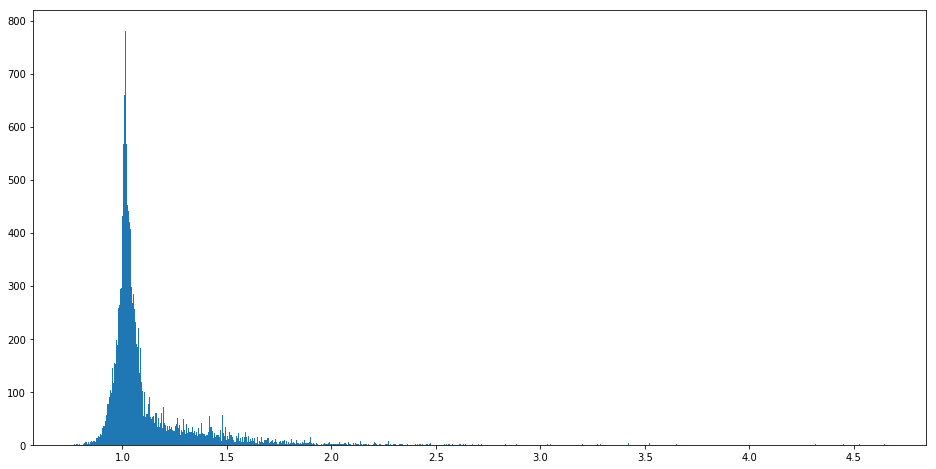

(1.1150048096609639, 0.23016395847754728, 4.6506573835379132)

In [67]:
#Estimation distribution
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(predictions)):
    estimations.append(predictions[idx].est)

plt.hist(estimations,bins=1000)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations)

### 4.2 Prec&Rec 

In [96]:
# top_n_all = get_top_n(predictions, n=k)
# top_n_possible = get_top_n(possible_predictions, n=k)
# # Print the recommended items for each user
# for uid, user_ratings in top_n_possible.items():
#     print(uid, [iid for (iid, _) in user_ratings], '\n')

k = 40
threshold = .9

precisions_all, recalls_all = precision_recall_at_k(predictions, k=k, threshold=threshold)
precisions_possible, recalls_possible = precision_recall_at_k(possible_predictions, k=k, threshold=threshold)

# Precision and recall can then be averaged over all users
print('Precision for all:        '+str(sum(prec for prec in precisions_all.values()) / len(precisions_all)))
# print('Precision for possible:   '+str(sum(prec for prec in precisions_possible.values()) / len(precisions_possible)))
print('Recall for all:           '+str(sum(rec for rec in recalls_all.values()) / len(recalls_all)))
# print('Recall for possible:      '+str(sum(rec for rec in recalls_possible.values()) / len(recalls_possible)))

Precision for all:        1.0
Recall for all:           0.983970899339
